# DOPPELGANGER #

## Ever wondered how your "doppelganger" dog would look like? 

# EXPERIMENT LOCALLY

### Prepare Environment
Install and import needed modules.

In [ ]:
import numpy as np
import pandas as pd
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Set image path and explore enivornment.

In [ ]:
images_path = 'code/training/Images'
len(os.listdir(os.path.join(images_path)))

Set parameters.

In [ ]:
batch_size = 200
img_w_size = 299
img_h_size = 299

Build Data Generator

In [ ]:
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

image_generator = datagen.flow_from_directory(
    images_path,
    target_size=(img_w_size, img_h_size),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)

In [ ]:
images = image_generator.next()
images.shape

### Show a sample picture!

In [ ]:
sample_image_idx = 1
plt.imshow((images[sample_image_idx] + 1) / 2)

## Transform Images to Lower Feature Space (Bottleneck) ##

In [ ]:
base_model = Xception(include_top=False,
                      weights='imagenet',
                      input_shape=(img_w_size, img_h_size, 3),
                      pooling='avg')

In [ ]:
bottlenecks = base_model.predict(images)
bottlenecks.shape

### Show Bottleneck

In [ ]:
plt.plot(bottlenecks[0])
plt.show()

In [ ]:
from sklearn.neighbors import DistanceMetric
dist = DistanceMetric.get_metric('euclidean')

### Calculate pairwise distances

In [ ]:
bn_dist = dist.pairwise(bottlenecks)
bn_dist.shape

## Pre-Process Image Similarities ##

In [ ]:
plt.imshow(bn_dist, cmap='gray')

Set visualization parameters.

In [ ]:
n_rows = 5
n_cols = 5
n_result_images = n_rows * n_cols

# Find Similar Images #

## Define `image_search()`

In [ ]:
def image_search(img_index, n_rows=n_rows, n_columns=n_cols):
    n_images = n_rows * n_cols

    # create Pandas Series with distances from image
    dist_from_sel = pd.Series(bn_dist[img_index])
    
    # sort Series and get top n_images
    retrieved_indexes = dist_from_sel.sort_values().head(n_images)
    retrieved_images = []
    
    # create figure, loop over closest images indices 
    # and display them
    plt.figure(figsize=(10, 10))
    i = 1
    for idx in retrieved_indexes.index:
        plt.subplot(n_rows, n_cols, i)
        plt.imshow((images[idx] + 1) / 2)
        if i == 1:
            plt.title('Selected image')
        else:
            plt.title("Dist: {:0.4f}".format(retrieved_indexes[idx]))
        i += 1
        retrieved_images += [images[idx]]
        
    plt.tight_layout()
    
    return np.array(retrieved_images)

## Perform Image Search

In [ ]:
similar_to_idx = 0
plt.imshow((images[similar_to_idx] + 1) / 2)

similar_images_sorted = image_search(similar_to_idx)
similar_images_sorted.shape

## Convert images to gray-scale ##

In [ ]:
grayscaled_similar_images_sorted = similar_images_sorted.mean(axis=3)
flattened_grayscale_images = grayscaled_similar_images_sorted.reshape(n_result_images, -1)
flattened_grayscale_images.shape

In [ ]:
_, h, w = grayscaled_similar_images_sorted.shape

# Compute a PCA 
n_components = 10

pca = PCA(n_components=n_components, whiten=True).fit(flattened_grayscale_images)

# apply PCA transformation to training data
pca_transformed = pca.transform(flattened_grayscale_images)

## Visualize Eigenfaces

In [ ]:
def plot_gallery(images, titles, h, w, rows=n_rows, cols=n_cols):
    plt.figure()
    for i in range(rows * cols):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i].reshape(h, w), cmap=plt.cm.gray)
        plt.title(titles[i])
        plt.xticks(())
        plt.yticks(())

eigenfaces = pca.components_.reshape((n_components, h, w))
eigenface_titles = ["eigenface {0}".format(i) for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w, 3, 3)

plt.show()

## Show Average Face

In [ ]:
average_face = eigenfaces[9]
plt.imshow((average_face + 1) / 2)

# BUILD CONTAINER

In [25]:
!cat code/training/doppelganger-train.py

# References:
#  https://towardsdatascience.com/an-intuitive-guide-to-deep-network-architectures-65fdc477db41
#  https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances.html

import numpy as np
import pandas as pd
import os
import time
import random
import json

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input

from sklearn.neighbors import DistanceMetric

images_path = 'images/'
batch_size = 200
img_w_size = 299
img_h_size = 299

print('** LOADING IMAGES **')
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
image_generator = datagen.flow_from_directory(
            images_path,
            target_size=(img_w_size, img_h_size),
            batch_size=batch_size,
            class_mode=None,
            shuffle=False)
# Note:  This needs to stay up here because we use it later to resolve the i

In [26]:
!cat code/training/Dockerfile

FROM python:3.6-slim

COPY images/ images/

COPY requirements.txt requirements.txt
RUN pip install -r requirements.txt

COPY doppelganger-train.py doppelganger-train.py
CMD [ "python", "doppelganger-train.py" ]



In [27]:
!cat code/training/doppelganger-train-deploy.yaml

apiVersion: v1
kind: Pod
metadata:
  name: doppelganger-train
  namespace: deployment
  labels:
    app: doppelganger-train
    type: training
    framework: tensorflow
spec:
  restartPolicy: OnFailure
  containers:
  - name: doppelganger-train
    image: antjebarth/doppelganger-train:1.0.0 
    imagePullPolicy: Always
    command:
      - "python"
      - "doppelganger-train.py"
#    env:
#      - name: AWS_REGION
#        value: eu-central-1


# RUN TRAINING POD
Deploy the training job to Kubernetes

In [33]:
!kubectl create -f code/training/doppelganger-train-deploy.yaml

pod/doppelganger-train created


In [39]:
!kubectl logs doppelganger-train -c doppelganger-train --namespace deployment

/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [32]:
!kubectl delete -f code/training/doppelganger-train-deploy.yaml

pod "doppelganger-train" deleted


# RUN INFERENCE POD
Use the previously trained model and run an inference service on Kubernetes

In [35]:
!cat code/inference/DoppelgangerModel.py

import keras
import sys
import numpy as np
import json

class DoppelgangerModel(object):
    def __init__(self):
        print("\n** LOADING MODEL from pairwise_top_25.json **")
        with open('pairwise_top_25.json') as fp:
            self.model = json.load(fp) 
        print("\n** LOADED MODEL from pairwise_top_25.json **")

    def predict(self, X, feature_names):
        similar_image_arr = self.model[str(int(X[0]))]
        return similar_image_arr

if __name__== "__main__":
    model = DoppelgangerModel()
    print(model.predict([0], ['image_id']))


In [36]:
!cat code/inference/Dockerfile-v1

FROM python:3.6-slim

COPY ./requirements.txt /app/requirements.txt
WORKDIR /app
RUN pip install -r requirements.txt
COPY DoppelgangerModel.py /app
COPY pairwise_top_25_v1.json pairwise_top_25.json

ENV MODEL_NAME DoppelgangerModel 
ENV API_TYPE REST
ENV SERVICE_TYPE MODEL
ENV PERSISTENCE 0

EXPOSE 5000 

CMD exec seldon-core-microservice $MODEL_NAME $API_TYPE --service-type $SERVICE_TYPE --persistence $PERSISTENCE


In [37]:
!cat code/inference/doppelganger-predict-deploy.yaml

apiVersion: machinelearning.seldon.io/v1alpha2
kind: SeldonDeployment
metadata:
  generation: 1
  labels:
    app: seldon
  name: doppelganger-model
  namespace: deployment
spec:
  annotations:
    seldon.io/engine-log-message-type: seldon.message.pair
    seldon.io/engine-log-messages-externally: "false"
    seldon.io/engine-log-requests: "false"
    seldon.io/engine-log-responses: "false"
    seldon.io/headless-svc: "false"
  name: doppelganger-model
  predictors:
  - componentSpecs:
    - spec:
        containers:
        - env:
          - name: LOG_LEVEL
            value: INFO
          - name: PREDICTIVE_UNIT_SERVICE_PORT
            value: "5000"
          - name: PREDICTIVE_UNIT_ID
            value: recommender
          - name: PREDICTOR_ID
            value: doppelganger-model 
          - name: SELDON_DEPLOYMENT_ID
            value: doppelganger-model
          image: antjebarth/doppelganger-predict:1.0.0 
          imagePullPolicy: Always 
          lifecycle:
          

### Deploy the service

In [41]:
!kubectl create -f code/inference/doppelganger-predict-deploy.yaml

seldondeployment.machinelearning.seldon.io/doppelganger-model created


### Make a prediction

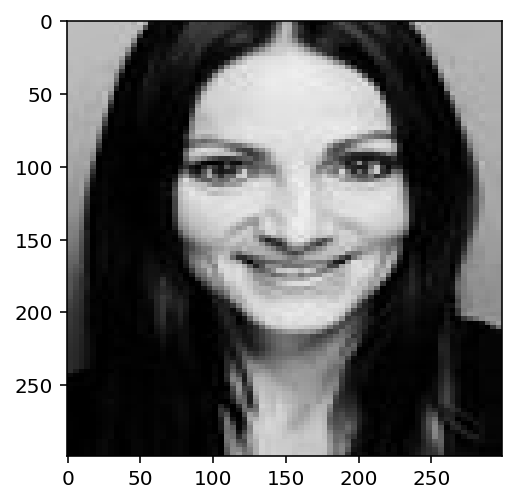

In [22]:
plt.imshow((images[0] + 1) / 2)

### Run a curl command to get a prediction from the REST API

In [47]:
!curl https://community.cloud.pipeline.ai/seldon/deployment/doppelganger-model/api/v0.1/predictions -d '{"data":{"ndarray":[[0]]}}' -H "Content-Type: application/json"

{
  "meta": {
    "puid": "ulq75rkrs2ur6kbsm9g4t8lp2s",
    "tags": {
    },
    "routing": {
    },
    "requestPath": {
      "recommender": "antjebarth/doppelganger-predict:1.0.0"
    },
    "metrics": []
  },
  "data": {
    "names": [],
    "ndarray": ["http://c0198e9d-istiosystem-istio-2af2-1928351968.eu-central-1.elb.amazonaws.com/notebook/doppelganger/doppelganger/view/doppelganger/code/training/images/n02085620-Chihuahua/n02085620_10976.jpg", "http://c0198e9d-istiosystem-istio-2af2-1928351968.eu-central-1.elb.amazonaws.com/notebook/doppelganger/doppelganger/view/doppelganger/code/training/images/n02087046-toy_terrier/n02087046_3211.jpg", "http://c0198e9d-istiosystem-istio-2af2-1928351968.eu-central-1.elb.amazonaws.com/notebook/doppelganger/doppelganger/view/doppelganger/code/training/images/n02089973-English_foxhound/n02089973_2484.jpg", "http://c0198e9d-istiosystem-istio-2af2-1928351968.eu-central-1.elb.amazonaws.com/notebook/doppelganger/doppelganger/view/doppelganger/code/t

### Clean up

In [ ]:
!kubectl delete -f code/inference/doppelganger-predict-deploy.yaml